# Capstone Project: Battle of the Neighborhoods

## Table of Contents

* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

The aim of this project is to compare the cities of New York, NY, USA and Toronto, ON, Canada.  Specifically by comparing neighborhoods <br>
between two cities to see which are most similar to each other. <br>
<br>
This can be done by clustering the neighborhoods in the respective cities, New York and Toronto, showing which neighborhoods are most alike <br>
and which are most dissimilar.  Such analysis could be used by businesses, such as restaurants, that see success in one city and are looking <br>
to expand to the other city.  For example, if an Italian restaurant in Toronto was looking to open a new location in New York the knowledge of <br>
which neighborhoods in New York are most similar to those in Toronto would improve the chances of the new location succeeding. <br>
<br>
By implementing machine learning methods we will measure the similarities between neighborhoods.  By doing so the most similar neighborhoods <br>
in both cities will be grouped and clearly displayed.

## Data <a name="data"></a>

In order to solve the problem previously put forward, we will need the following for New York and Toronto:
* Geographic data of the neighborhoods 
* The number of different types of venues in each neighborhood


The sources of data to be used are the following:

* https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M (A table of postal codes and neighborhoods in Toronto)
* Geospatial_Coordinates.csv (A csv of the latitude and longitude of postal codes in Toronto)
* newyork_data.json (A json file of New York neighborhood latitude and longitude data)
* Foursquare API (To obtain the number of venues in each neighborhood)

### Toronto Data

In [4]:
# import pandas
import pandas as pd

# read toronto postal code and neighborhood data
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1012118802'
postal_df = pd.read_html(url)[0]
postal_df = postal_df.loc[postal_df['Borough'] != 'Not assigned']

# read postal code and lat/long data
lat_long_df = pd.read_csv('Geospatial_Coordinates.csv')

# merge the 2 dfs
toronto_df = postal_df.merge(lat_long_df, on='Postal Code')

# display toronto df
print(toronto_df.shape)
toronto_df.head()

(103, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


#### Map Of Toronto Neighborhoods

In [6]:
# import Nominatim
from geopy.geocoders import Nominatim
import folium

address = 'Toronto, Golden Horseshoe, Ontario, Canada'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, long, borough, neighbourhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Get Foursquare Credentials

In [7]:
with open('foursquare credentials.txt', 'r') as creds:
    _ = creds.readline()
    CLIENT_ID = creds.readline()
    _ = creds.readline()
    _ = creds.readline()
    CLIENT_SECRET = creds.readline()
    _ = creds.readline()
    _ = creds.readline()
    _ = creds.readline()
    _ = creds.readline()
    _ = creds.readline()
    ACCESS_TOKEN = creds.readline()

VERSION = '20180605' # Foursquare API version
LIMIT = 1000 # A default Foursquare API limit value


#### Function To Get Venues

In [10]:
import requests

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get Venues For Toronto Neighborhoods

In [11]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

#### Count Of Venue Type For Each Toronto Neighborhood

In [12]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### New York Data

In [14]:
import json

# read in new york data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
newyork_df = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_df = newyork_df.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
print(newyork_df.shape)
newyork_df.head()

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Map Of New York Neighborhoods

In [15]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(newyork_df['Latitude'], newyork_df['Longitude'], newyork_df['Borough'], newyork_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Get Venues For New York Neighborhoods

In [19]:
newyork_venues = getNearbyVenues(names=newyork_df['Neighborhood'],
                                   latitudes=newyork_df['Latitude'],
                                   longitudes=newyork_df['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

#### Count Of Venue Type For Each New York Neighborhood

In [39]:
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_grouped = newyork_onehot.groupby('Neighborhood').sum().reset_index()
newyork_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant
0,Allerton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Annadale,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Arden Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arlington,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Arrochar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Ensure Toronto Grouped Has Same Columns As New York Grouped

In [21]:
import numpy as np
notin_toronto = list(set(newyork_grouped.columns).difference(set(toronto_grouped.columns)))
zero_arr = np.zeros(shape=(toronto_grouped.shape[0],len(notin_toronto)))
zero_df = pd.DataFrame(zero_arr,columns=notin_toronto)
toronto_grouped = pd.concat([toronto_grouped, zero_df], axis='columns', join='inner')
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Hostel,College Cafeteria,Outdoor Sculpture,Campground,Memorial Site,Automotive Shop,Rental Service,Leather Goods Store,Dive Bar,Insurance Office
0,Agincourt,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Ensure New York Grouped Has Same Columns As Toronto Grouped

In [40]:
notin_newyork = list(set(toronto_grouped.columns).difference(set(newyork_grouped.columns)))
zero_arr = np.zeros(shape=(newyork_grouped.shape[0], len(notin_newyork)))
zero_df = pd.DataFrame(zero_arr, columns=notin_newyork)
newyork_grouped = pd.concat([newyork_grouped, zero_df], axis='columns', join='inner')
newyork_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,...,Auto Garage,Curling Ice,Theme Restaurant,College Stadium,Hockey Arena,Belgian Restaurant,Airport Lounge,Bed & Breakfast,Hakka Restaurant,Poutine Place
0,Allerton,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0,0,0,0,0,0,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Methodology <a name="methodology"></a>

The goal of this project is to identify which New York neighborhoods are the most similar to Toronto neighborhoods. <br>
By doing this a successful business in one city looking to expand to the other can choose similar neighborhoods to the one <br>
it has already proven successful in. <br>
<br>
The first step, shown in the data section, was to gather data on the neighborhoods of the two cities such as the neighborhoods <br>
and what businesses and attractions are in each neighborhood. <br>
<br>
The second step is to conduct a visual analysis using techniques like correlation and heatmaps to gain an intuitive idea of which <br>
neighborhoods are likely candidates for a business expansion.<br>
<br>
The third and final step is to use clustering techniques, specifically heirarchical clusting, in order to group the most similar <br>
neighborhoods within and inbetween the two cities.  Using this information will present the clearest picture of which neighborhoods <br>
are the most similar and therefore which neighborhoods a business should consider when looking to expand to the new city.

## Analysis <a name="analysis"></a>

Before jumping into clustering let's visualize the data to see what take aways can be gathered.

In [41]:
# corr and heatmap for just new york
newyork_grouped.set_index('Neighborhood', inplace=True)
newyork = newyork_grouped.transpose()
newyork

Neighborhood,Allerton,Annadale,Arden Heights,Arlington,Arrochar,Arverne,Astoria,Astoria Heights,Auburndale,Bath Beach,...,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Wingate,Woodhaven,Woodlawn,Woodrow,Woodside,Yorkville
Yoga Studio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Accessories Store,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adult Boutique,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Afghan Restaurant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Belgian Restaurant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Airport Lounge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bed & Breakfast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hakka Restaurant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


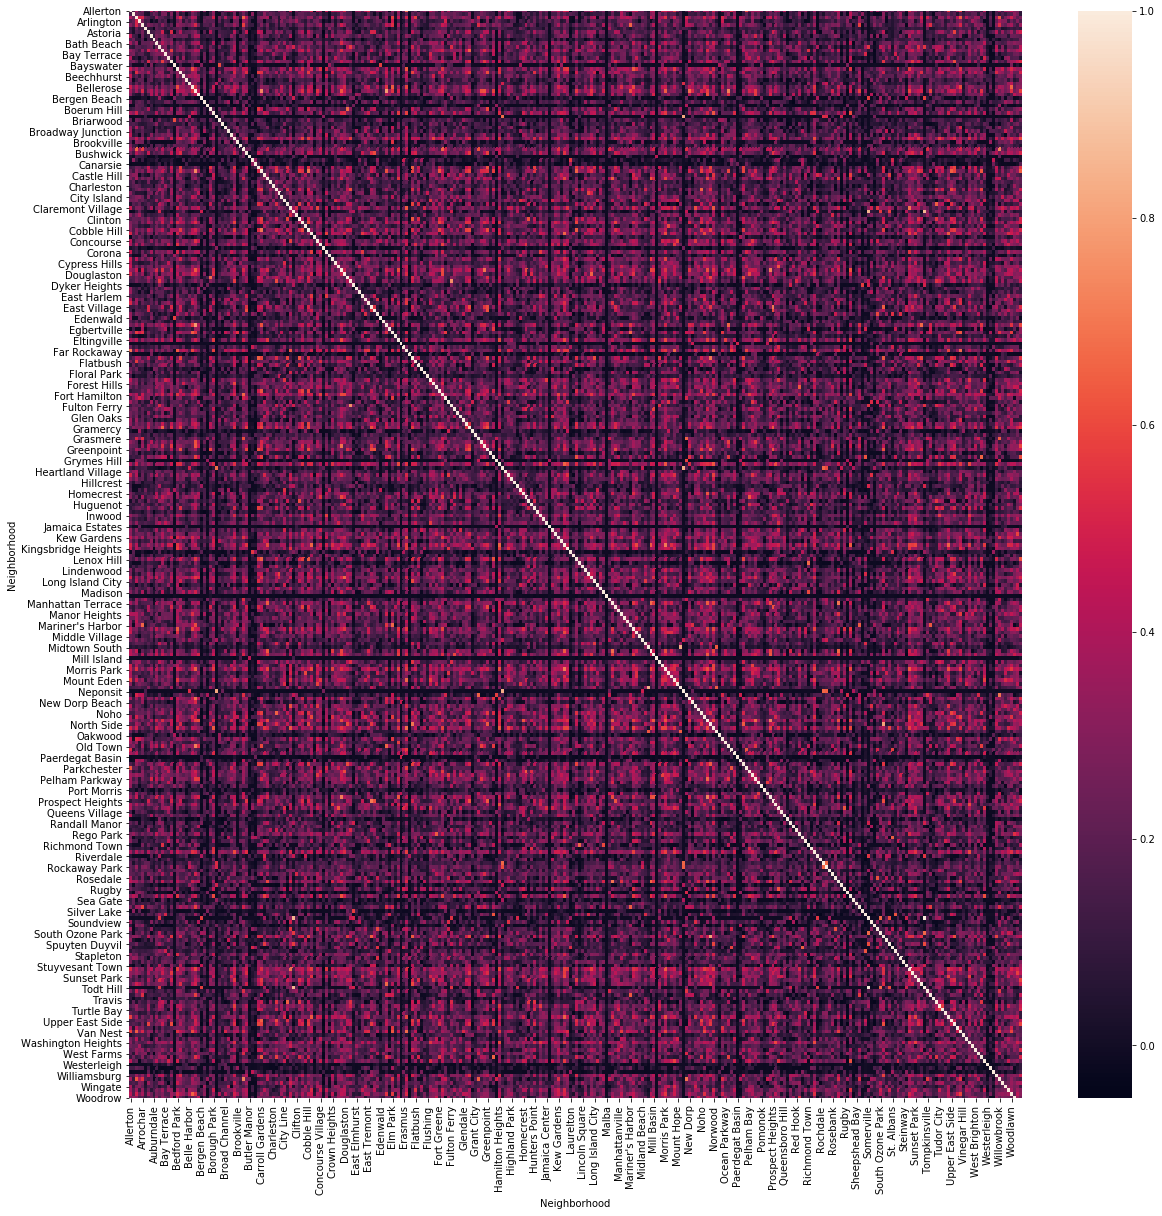

In [59]:
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt

newyork_corr = newyork.corr()
# newyork_corr
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(newyork.corr(), ax=ax)
ax


In [82]:
# corr and heatmap for just Toronto
toronto_grouped.set_index('Neighborhood', inplace=True)
toronto = toronto_grouped.transpose()
toronto

KeyError: "None of ['Neighborhood'] are in the columns"

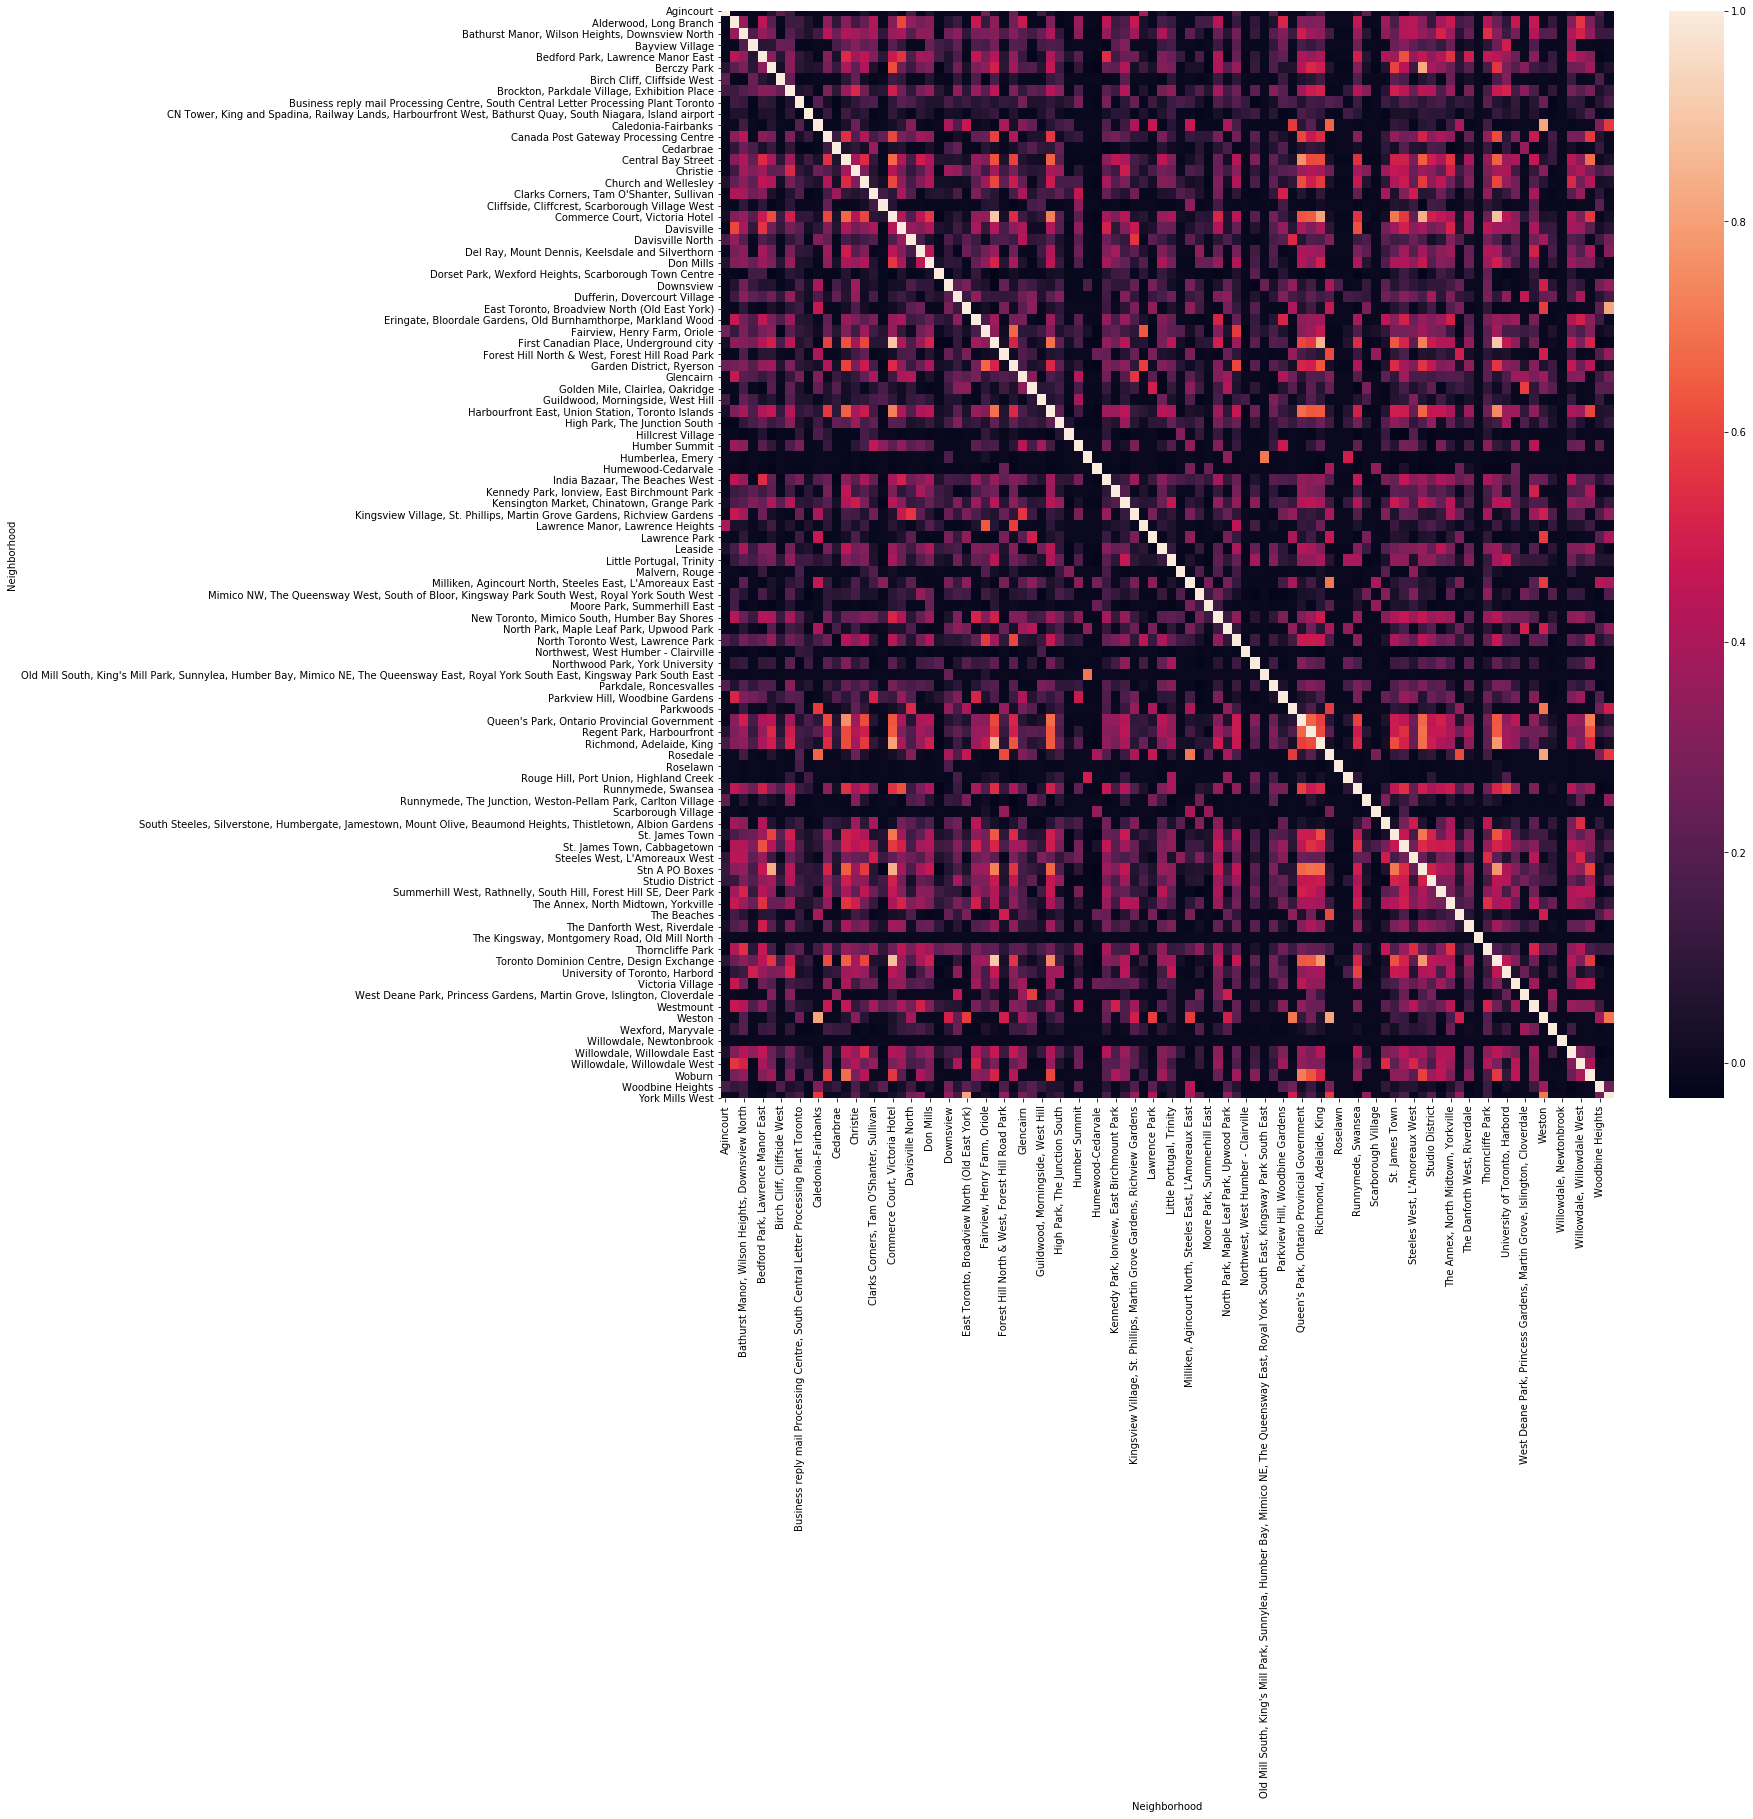

In [61]:
toronto_corr = toronto.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(toronto.corr(), ax=ax)
ax

Comments on visual analysis

In [83]:
# scale data
from sklearn.preprocessing import StandardScaler
ny = newyork_grouped.values[:,1:]
ny = np.nan_to_num(ny)
ny_dataSet = StandardScaler().fit_transform(ny)
ny_dataSet

array([[-0.05783149, -0.19509558, -0.08192319, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05783149, -0.19509558, -0.08192319, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05783149, -0.19509558, -0.08192319, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.05783149, -0.19509558, -0.08192319, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05783149, -0.19509558, -0.08192319, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05783149, -0.19509558, -0.08192319, ...,  0.        ,
         0.        ,  0.        ]])

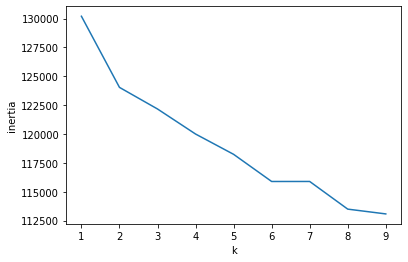

In [86]:
# finding k
from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(ny_dataSet)
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias)
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

k of 6 looks to be the elbow points and for this project we will go with a k of 6.

In [88]:
newyork_grouped.drop(['Cluster Labels'], axis = 1, inplace = True) 

In [89]:
k = 6
kmeans = KMeans(n_clusters=k)
kmeans.fit(ny_dataSet)
newyork_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
newyork_grouped.head()

,Cluster Labels,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House

In [90]:
# fit to toronto
to = toronto_grouped.values[:,1:]
to = np.nan_to_num(to)
to_dataSet = StandardScaler().fit_transform(to)

kmeans.fit(to_dataSet)
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_grouped.head()

,Cluster Labels,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Polish Restaurant,Waste Facility,Go Kart Track,Road,Cafeteria,Romanian Restaurant,Arepa Restaurant,High School,Gymnastics Gym,Stables,Kosher Restaurant,Toll Pl

### Cluster 0

In [107]:
list(newyork_grouped.loc[newyork_grouped['Cluster Labels'] == 0, newyork_grouped.columns[[1] + list(range(5, newyork_grouped.shape[1]))]].index)

['Greenpoint', 'Little Neck']

In [108]:
list(toronto_grouped.loc[toronto_grouped['Cluster Labels'] == 0, toronto_grouped.columns[[1] + list(range(5, toronto_grouped.shape[1]))]].index)

['Agincourt',
 'Alderwood, Long Branch',
 'Bathurst Manor, Wilson Heights, Downsview North',
 'Bayview Village',
 'Bedford Park, Lawrence Manor East',
 'Birch Cliff, Cliffside West',
 'Brockton, Parkdale Village, Exhibition Place',
 'Business reply mail Processing Centre, South Central Letter Processing Plant Toronto',
 'CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport',
 'Caledonia-Fairbanks',
 'Canada Post Gateway Processing Centre',
 'Cedarbrae',
 'Central Bay Street',
 'Christie',
 "Clarks Corners, Tam O'Shanter, Sullivan",
 'Cliffside, Cliffcrest, Scarborough Village West',
 'Davisville',
 'Davisville North',
 'Del Ray, Mount Dennis, Keelsdale and Silverthorn',
 'Don Mills',
 'Dorset Park, Wexford Heights, Scarborough Town Centre',
 'Downsview',
 'Dufferin, Dovercourt Village',
 'East Toronto, Broadview North (Old East York)',
 'Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood',
 'Fairview, Henry Farm, Oriole',

### Cluster 1

In [109]:
list(newyork_grouped.loc[newyork_grouped['Cluster Labels'] == 1, newyork_grouped.columns[[1] + list(range(5, newyork_grouped.shape[1]))]].index)

['Tribeca']

In [110]:
list(toronto_grouped.loc[toronto_grouped['Cluster Labels'] == 1, toronto_grouped.columns[[1] + list(range(5, toronto_grouped.shape[1]))]].index)

['Commerce Court, Victoria Hotel',
 'First Canadian Place, Underground city',
 'Richmond, Adelaide, King',
 'Toronto Dominion Centre, Design Exchange']

### Cluster 2

In [111]:
list(newyork_grouped.loc[newyork_grouped['Cluster Labels'] == 2, newyork_grouped.columns[[1] + list(range(5, newyork_grouped.shape[1]))]].index)

['Allerton',
 'Annadale',
 'Arden Heights',
 'Arlington',
 'Arrochar',
 'Arverne',
 'Astoria Heights',
 'Auburndale',
 'Bath Beach',
 'Bay Terrace',
 'Baychester',
 'Bayswater',
 'Bedford Park',
 'Bedford Stuyvesant',
 'Beechhurst',
 'Bellaire',
 'Belle Harbor',
 'Bellerose',
 'Bensonhurst',
 'Bergen Beach',
 'Blissville',
 'Bloomfield',
 'Borough Park',
 'Breezy Point',
 'Briarwood',
 'Brighton Beach',
 'Broad Channel',
 'Broadway Junction',
 'Bronxdale',
 'Brookville',
 'Brownsville',
 'Bulls Head',
 'Butler Manor',
 'Cambria Heights',
 'Canarsie',
 'Castle Hill',
 'Castleton Corners',
 'Central Harlem',
 'Charleston',
 'City Island',
 'City Line',
 'Claremont Village',
 'Clason Point',
 'Clifton',
 'Co-op City',
 'College Point',
 'Concord',
 'Concourse',
 'Concourse Village',
 'Coney Island',
 'Corona',
 'Country Club',
 'Crown Heights',
 'Cypress Hills',
 'Ditmas Park',
 'Dongan Hills',
 'Douglaston',
 'Dyker Heights',
 'East Elmhurst',
 'East Flatbush',
 'East Harlem',
 'East New

In [112]:
list(toronto_grouped.loc[toronto_grouped['Cluster Labels'] == 1, toronto_grouped.columns[[1] + list(range(5, toronto_grouped.shape[1]))]].index)

['Commerce Court, Victoria Hotel',
 'First Canadian Place, Underground city',
 'Richmond, Adelaide, King',
 'Toronto Dominion Centre, Design Exchange']

### Cluster 3

In [113]:
list(newyork_grouped.loc[newyork_grouped['Cluster Labels'] == 3, newyork_grouped.columns[[1] + list(range(5, newyork_grouped.shape[1]))]].index)

['Lincoln Square']

In [114]:
list(toronto_grouped.loc[toronto_grouped['Cluster Labels'] == 1, toronto_grouped.columns[[1] + list(range(5, toronto_grouped.shape[1]))]].index)

['Commerce Court, Victoria Hotel',
 'First Canadian Place, Underground city',
 'Richmond, Adelaide, King',
 'Toronto Dominion Centre, Design Exchange']

### Cluster 4

In [115]:
list(newyork_grouped.loc[newyork_grouped['Cluster Labels'] == 4, newyork_grouped.columns[[1] + list(range(5, newyork_grouped.shape[1]))]].index)

['Murray Hill']

In [116]:
list(toronto_grouped.loc[toronto_grouped['Cluster Labels'] == 1, toronto_grouped.columns[[1] + list(range(5, toronto_grouped.shape[1]))]].index)

['Commerce Court, Victoria Hotel',
 'First Canadian Place, Underground city',
 'Richmond, Adelaide, King',
 'Toronto Dominion Centre, Design Exchange']

### Cluster 5

In [117]:
list(newyork_grouped.loc[newyork_grouped['Cluster Labels'] == 5, newyork_grouped.columns[[1] + list(range(5, newyork_grouped.shape[1]))]].index)

['Astoria',
 'Battery Park City',
 'Bay Ridge',
 'Bayside',
 'Belmont',
 'Boerum Hill',
 'Brooklyn Heights',
 'Bushwick',
 'Carnegie Hill',
 'Carroll Gardens',
 'Chelsea',
 'Chinatown',
 'Civic Center',
 'Clinton',
 'Clinton Hill',
 'Cobble Hill',
 'Downtown',
 'Dumbo',
 'East Village',
 'East Williamsburg',
 'Financial District',
 'Flatiron',
 'Flushing',
 'Fort Greene',
 'Gramercy',
 'Greenwich Village',
 'Hudson Yards',
 'Hunters Point',
 'Jackson Heights',
 'Lenox Hill',
 'Little Italy',
 'Long Island City',
 'Midtown',
 'Midtown South',
 'Noho',
 'North Side',
 'Park Slope',
 'Prospect Heights',
 'Soho',
 'South Side',
 'Sunnyside Gardens',
 'Sutton Place',
 'Tudor City',
 'Turtle Bay',
 'Upper East Side',
 'Upper West Side',
 'Washington Heights',
 'West Village',
 'Woodside',
 'Yorkville']

In [118]:
list(toronto_grouped.loc[toronto_grouped['Cluster Labels'] == 1, toronto_grouped.columns[[1] + list(range(5, toronto_grouped.shape[1]))]].index)

['Commerce Court, Victoria Hotel',
 'First Canadian Place, Underground city',
 'Richmond, Adelaide, King',
 'Toronto Dominion Centre, Design Exchange']

In [122]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [152]:
# merge lat and long to toronto neighborhoods
toronto_df.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
toronto_merged = toronto_df.set_index('Neighborhood')
toronto_merged = toronto_merged.join(toronto_grouped)
toronto_merged.reset_index(inplace=True)
toronto_merged.dropna(inplace=True)

toronto_merged.head()

,Neighborhood,Postal Code,Borough,Latitude,Longitude,Cluster Labels,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Polish Restaurant,Waste Facility,Go Kart Track,Road,Cafeteria,Romanian Restaurant,Arepa Restaurant,High Sch

In [153]:
# merge lat and long to newyork neighborhoods
newyork_merged = newyork_df.set_index('Neighborhood')
newyork_merged = newyork_merged.join(newyork_grouped)
newyork_merged.reset_index(inplace=True)
newyork_merged.dropna(inplace=True)

newyork_merged.head()

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,No

In [162]:
# visualization of toronto clusters on map
to_latitude = 43.6532
to_longitude = -79.3832

to_map_clusters = folium.Map(location=[to_latitude, to_longitude], zoom_start=11)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(to_map_clusters)

to_map_clusters

In [164]:
# visualization of newyork clusters on map
ny_latitude = 40.7128
ny_longitude = -74.0060
ny_map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(ny_map_clusters)
    
ny_map_clusters

## Results <a name="results"></a>

The above analysis shows that for the most part neighborhoods in New York are not very similar to neighborhoods in Toronto; however, there <br>
are some neighborhoods that at least according to our cluster analysis share similiarities to a degree.  In particular most Toronto <br>
neighborhoods belong to cluster 0 (shown in red); whereas, most neighborhoods in New York belong to cluster 2 (shown in blue).  Despite <br>
New York and Toronto neighborhoods overall not being similar their are specific areas that are closer related.<br>

The largest cluster in Toronto also contains Greenpoint and Little Neck from New York, the largest New York cluster contains Commerce Court,<br>
Victoria Hotel, First Canadian Place, Underground city, Richmond, Adelaide, King, Toronto Dominion Centre, and Design Exchange from Toronto. <br>
This shows that our analysis can be used situationally for a business looking to move from New York to Toronto and can allow them to rule out <br>
most neighborhoods for expansion.<br>

Additionally, this clustering analysis finds that the outlying areas of both Toronto and New York belong to the largest clusters and are most similar. <br>
New York in particlular is interesting as Manhattan appears to have its own cluster as well (shown in orange).<br>

## Conclusion <a name="conclusion"></a>

This project is a good starting point to advising businesses looking to move from New York to Toronto, or vice versa, which neighborhoods to <br>
consider.  However, more questions and further analysis should be done.  Additional variables may prove helpful for analysis such as crime rates, <br>
household income, property value, average education level, and access to public transportation.  Other clustering methods may prove to be more useful <br>
like hierarchical clustering or density based clustering.  Finally, additionaly cities should be considered in the analysis and it would be interesting <br>
to see if other cities are more similar and follow the trend of outlying areas being predominatly of one cluster.